In [1]:
from qfrm2.American import *
from FNMethods.ImplicitAm import *
from Reinforcement.src.examples.american_pricing.american_pricing import *
from Reinforcement.src.examples.american_pricing.american_pricing import get_prices_LSPI_FQI
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.model_selection import train_test_split
import pandas as pd
%precision 3
pd.set_option("display.precision", 3)

In [2]:
def LSMC_inmoney(S0,K,signCP,rf_r,vol,T,rng_seed,deg,nsteps,npaths):
    rng_seed, deg, n, m = rng_seed, deg, nsteps, npaths

    dt = T/n
    df=np.exp(-rf_r*dt)

    S0, vol = S0, vol
    K, r, signCP = K, rf_r, signCP

    np.random.seed(rng_seed)
    norm_mtx = np.random.normal((r - 0.5 * vol ** 2) * dt, vol * math.sqrt(dt), (n , m))
    S=np.ones(shape=(n+1,m))*S0
    S[1:,:]=S0 * np.exp(np.cumsum(norm_mtx, axis=0))


    payout = np.maximum(signCP * (S - K), 0)
    v = np.copy(payout)  # terminal payouts
    X=np.where(S<K,S,np.nan)

    # Least-Squares Monte Carlo (LSM):
    for i in range(n - 1, 0, -1):          # American Option Valuation by Backwards Induction
        idx = np.isfinite(X[i])
        rg = np.polyfit(X[i][idx], v[i + 1][idx] * df,deg)      # fit 5th degree polynomial to PV of current inner values
        C = np.polyval(rg, X[i]) 
        C=np.where(np.isnan(C),0,C)
        v[i] = np.where(payout[i] > C, payout[i], v[i + 1] * df)  # exercise decision
    v[0] = v[1] * df
    return np.mean(v[0]),np.std(v[0],ddof=1)

In [3]:
def LSMC_GPR_inmoney(S0,K,signCP,rf_r,vol,T,rng_seed,train_size,nsteps,npaths):
    rng_seed, train_size, n, m = rng_seed, train_size, nsteps, npaths

    dt = T/n
    df=np.exp(-rf_r*dt)

    S0, vol = S0, vol
    K, r, signCP = K, rf_r, signCP

    np.random.seed(rng_seed)
    norm_mtx = np.random.normal((r - 0.5 * vol ** 2) * dt, vol * math.sqrt(dt), (n , m))
    S=np.ones(shape=(n+1,m))*S0
    S[1:,:]=S0 * np.exp(np.cumsum(norm_mtx, axis=0))
    

    payout = np.maximum(signCP * (S - K), 0)
    v = np.copy(payout)  # terminal payouts
    X=np.where(S<K,S,np.nan)

    # Least-Squares Monte Carlo (LSM):
    for i in range(n - 1, 0, -1):          # American Option Valuation by Backwards Induction
        idx = np.isfinite(X[i])
        X_train, _, y_train, _=train_test_split(X[i][idx],(v[i + 1] * df)[idx],train_size=train_size,\
                                                random_state=rng_seed)
        rbf = WhiteKernel()+ConstantKernel() * RBF()
        gpr = GaussianProcessRegressor(kernel=rbf,random_state=rng_seed,normalize_y=True)
        gpr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
        C = gpr.predict((X[i][idx]).reshape(-1,1))
        C2=np.zeros_like(X[i])
        C2[idx]=np.squeeze(C)
        C2[~idx]=X[i][~idx]
        C2=np.where(np.isnan(C2),0,C2)
        v[i] = np.where(payout[i] > C2, payout[i], v[i + 1] * df)  # exercise decision
        #if i%10==0:print(i)
    v[0] = v[1] * df
    return  np.mean(v[0])

In [23]:
def LSMC_GPR(S0,K,signCP,rf_r,vol,T,rng_seed,train_size,nsteps,npaths):
    rng_seed, train_size, n, m = rng_seed, train_size, nsteps, npaths

    dt = T/n
    df=np.exp(-rf_r*dt)

    S0, vol = S0, vol
    K, r, signCP = K, rf_r, signCP

    np.random.seed(rng_seed)
    norm_mtx = np.random.normal((r - 0.5 * vol ** 2) * dt, vol * math.sqrt(dt), (n , m))
    S=np.ones(shape=(n+1,m))*S0
    S[1:,:]=S0 * np.exp(np.cumsum(norm_mtx, axis=0))
    

    payout = np.maximum(signCP * (S - K), 0)
    v = np.copy(payout)  # terminal payouts

    # Least-Squares Monte Carlo (LSM):
    for i in range(n - 1, 0, -1):          # American Option Valuation by Backwards Induction
        X_train, _, y_train, _=train_test_split(S[i],(v[i + 1] * df),train_size=train_size, \
                                                random_state=rng_seed)
        rbf = WhiteKernel()+ConstantKernel() * RBF()
        gpr = GaussianProcessRegressor(kernel=rbf,random_state=rng_seed,normalize_y=True)
        gpr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
        C = np.squeeze(gpr.predict((S[i]).reshape(-1,1)))
        v[i] = np.where(payout[i] > C, payout[i], v[i + 1] * df)  # exercise decision
        #if i%10==0:print(i)
    v[0] = v[1] * df
    return  np.mean(v[0])

1. American Put Option

In [24]:
S0=[36,38,40,42,44]
K=40
r=0.06
sigma=[0.2,0.4]
T=[1,2]

In [368]:
method=['BS','LT','FD','LSM','GPR','FQI','LSPI']

In [8]:
iterables = [S0, sigma,T]
index = pd.MultiIndex.from_product(iterables, names=['S0', 'sigma','T'])
df = pd.DataFrame(np.zeros(shape=(20,7)),columns=['BS','LT','FD','LSM','GPR','FQI','LSPI'], index=index)

In [9]:
s = Stock(S0=S0[0], vol=sigma[0])
o = American(ref=s, right='put', K=K, T=T[0], rf_r=r)

In [16]:
#df.loc[(S0[0],sigma[0],T[0]),'BS']=1

In [ ]:
for i in S0:
    for j in sigma:
        for k in T:
            print(i,j,k)
            #s = Stock(S0=i, vol=j)
            #o = American(ref=s, right='put', K=K, T=k, rf_r=r)
            #df.loc[(i,j,k),'BS']=o.pxBS() #dont use it as it is actually LT + CV
            #df.loc[(i,j,k),'LT']=o.pxLT(nsteps=k*50)
            #df.loc[(i,j,k),'FD']=ImplicitAmBer(i,K,r,k,\
            #                                   j,100,M=1000, N=50*k,is_call=False).price()
            #df.loc[(i,j,k),'LSM']=LSMC_inmoney(i,K,-1,r,j,k,1,5,50*k,50000)
            #df.loc[(i,j,k),'LSPI'], df.loc[(i,j,k),'FQI']=get_prices_LSPI_FQI(\
            #                                           False,i,K,k,r,j,50*k,2000,200)
            if k <=42:
                df.loc[(i,j,k),'GPR']=LSMC_GPR_inmoney(i,K,-1,r,j,k,1,0.6,50*k,1000)
            else:
                df.loc[(i,j,k),'GPR']=LSMC_GPR(i,K,-1,r,j,k,1,0.6,50*k,1000)

Calculate s.e.

In [449]:
iterables = [S0, sigma,T]
index = pd.MultiIndex.from_product(iterables, names=['S0', 'sigma','T'])
df_se = pd.DataFrame(np.zeros(shape=(20,3)),columns=['LSM','GPR','FQI','LSPI'], index=index)

In [35]:
for i in [38,40,42,44]:
    for j in sigma:
        for k in T:
            print(i,j,k)

            #df_se.loc[(i,j,k),'LSM']=np.std([LSMC_inmoney(i,K,-1,r,j,k,1,5,50*k,100000) for q in range(50)],ddof=1)
            source_list=[get_prices_LSPI_FQI(False,i,K,k,r,j,50*k,100,10)  for q in range(50)]
        
            LSPI,FQI=zip(*source_list)
            df_se.loc[(i,j,k),'LSPI']=np.std(LSPI,ddof=1)
            df_se.loc[(i,j,k),'FQI']=np.std(FQI,ddof=1)
            #if i <=42:
             #   df_se.loc[(i,j,k),'GPR']=np.std([LSMC_GPR_inmoney(i,K,-1,r,j,k,q,0.6,50*k,1000) \
             #                                    for q in range(50)],ddof=1)
            #else:
             #   df_se.loc[(i,j,k),'GPR']=np.std([LSMC_GPR(i,K,-1,r,j,k,q,0.6,50*k,1000) \
              #                                   for q in range(50)],ddof=1)


38 0.2 1
38 0.2 2
38 0.4 1
38 0.4 2
40 0.2 1
40 0.2 2
40 0.4 1
40 0.4 2
42 0.2 1
42 0.2 2
42 0.4 1
42 0.4 2
44 0.2 1
44 0.2 2
44 0.4 1
44 0.4 2


In [40]:
df_se.to_csv('./Running results/SimpleAmericanPut_se') 
#df_se=pd.read_csv('SimpleAmericanPut_se',index_col=[0,1,2]) # load

In [444]:
#df.to_csv('SimpleAmericanPut')  # save 
#df=pd.read_csv('SimpleAmericanPut',index_col=[0,1,2]) # load

In [26]:
df_by_steps = pd.DataFrame(np.zeros(shape=(20,7)),columns=['BS','LT','FD','LSM','GPR','FQI','LSPI'], \
                           index=pd.Index(np.arange(10,210,10)))

In [423]:
df_by_steps

,BS,LT,FD,LSM,GPR,FQI,LSPI
10,2.325,2.285,2.235,2.276,2.242,2.087,2.105
20,2.325,2.304,2.275,2.287,2.206,2.109,2.035
30,2.325,2.309,2.289,2.298,2.255,2.224,2.308
40,2.325,2.311,2.296,2.299,2.188,2.233,2.227
50,2.325,2.313,2.300,2.311,2.173,2.253,2.212
60,2.325,2.314,2.303,2.315,2.170,2.139,2.166
70,2.325,2.315,2.306,2.319,2.184,2.183,2.265
80,2.325,2.316,2.307,2.325,2.159,2.094,2.132
90,2.325,2.316,2.309,2.332,2.095,2.220,2.291
100,2.325,2.316,2.310,2.329,2.086,2.049,2.245


In [422]:
for n in np.arange(10,210,10):
        print(n)
        i=40
        j=0.2
        k=1
        s = Stock(S0=i, vol=j)
        o = American(ref=s, right='put', K=K, T=k, rf_r=r)
        #df_by_steps.loc[n,'BS']=o.pxBS()
        #df_by_steps.loc[n,'LT']=o.pxLT(nsteps=n)
        #df_by_steps.loc[n,'FD']=ImplicitAmBer(i,K,r,k,\
        #                                   j,100,M=1000, N=n,is_call=False).price()
        #df_by_steps.loc[n,'LSM']=LSMC_inmoney(i,K,-1,r,j,k,1,5,n,50000)
        df_by_steps.loc[n,'GPR']=LSMC_GPR_inmoney(i,K,-1,r,j,k,1,0.4,n,1000)
        #df_by_steps.loc[n,'LSPI'], df_by_steps.loc[n,'FQI']=get_prices_LSPI_FQI(\
         #                                          False,i,K,k,r,j,n,2000,200)

200


In [147]:
#df_by_steps.to_csv('SimpleAmericanPutbySteps')

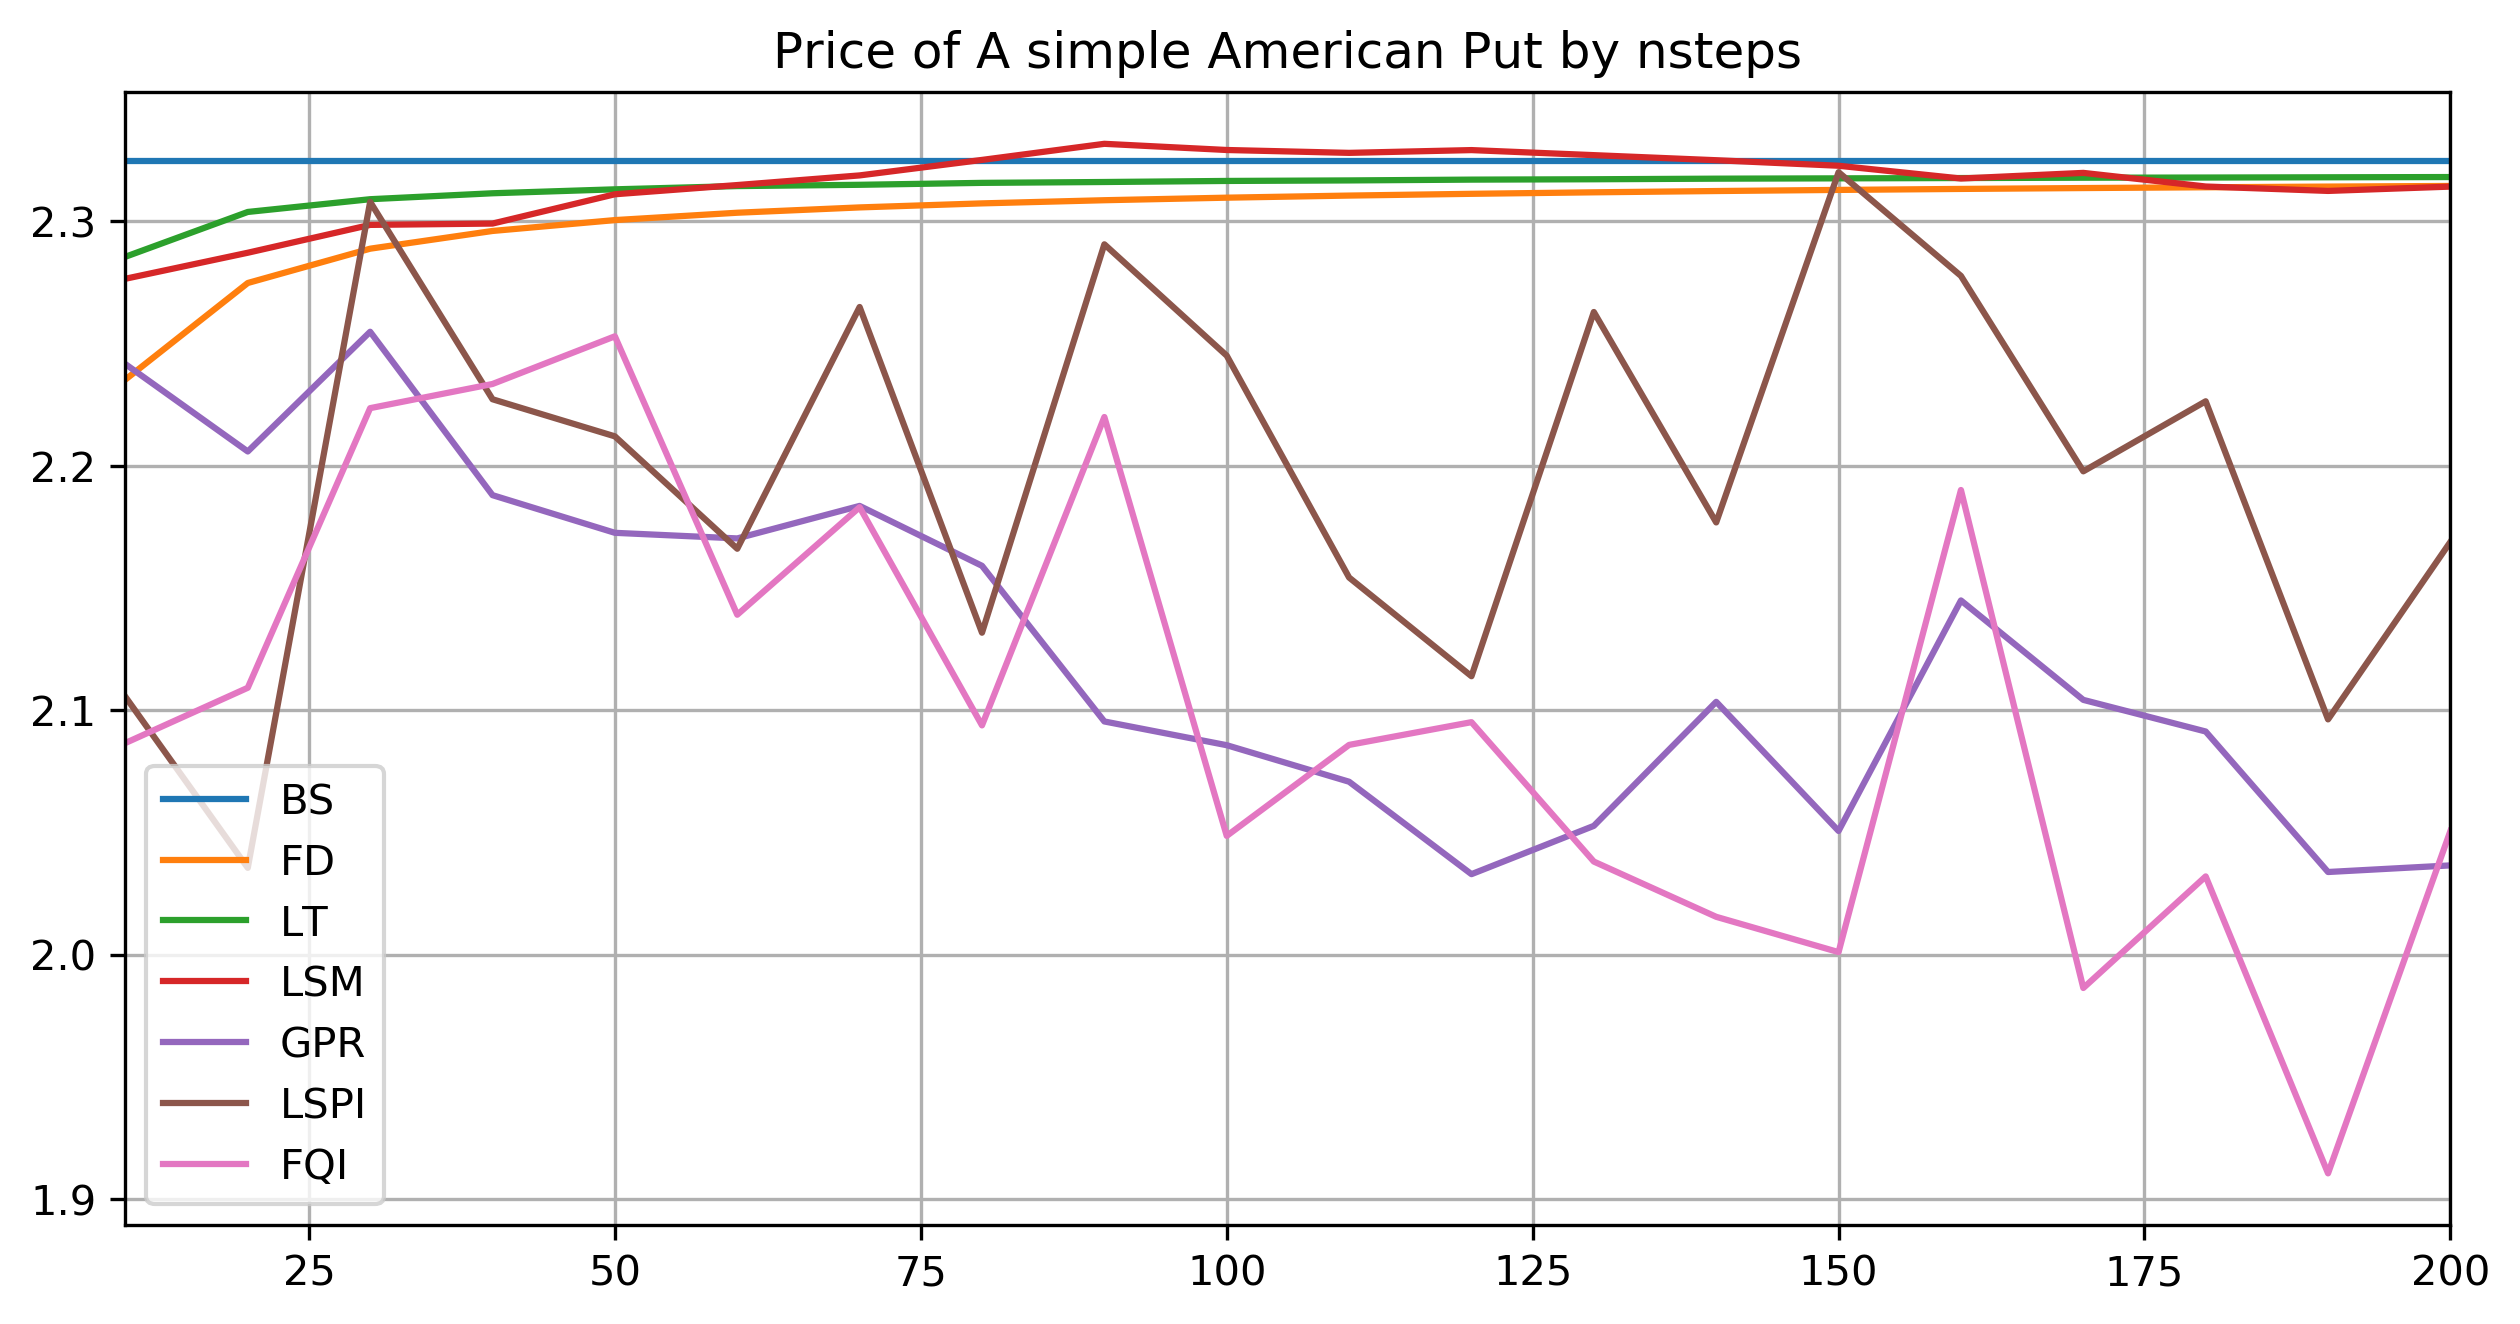

In [426]:
plt.rcParams["figure.dpi"] = 300
df_by_steps[['BS','FD','LT','LSM','GPR','LSPI','FQI']].\
plot(grid=0.1, title='Price of A simple American Put by nsteps',figsize=(10,5))

In [402]:
for i in [44]:
    for j in [0.4]:
        for k in [2]:
            print(i,j,k)
            #s = Stock(S0=i, vol=j)
            #o = American(ref=s, right='put', K=K, T=k, rf_r=r)
            #df.loc[(i,j,k),'BS']=o.pxBS()
            #df.loc[(i,j,k),'LT']=o.pxLT(nsteps=k*50)
            #df.loc[(i,j,k),'FD']=ImplicitAmBer(i,K,r,k,\
            #                                   j,100,M=1000, N=50*k,is_call=False).price()
            #df.loc[(i,j,k),'LSM']=LSMC_inmoney(i,K,-1,r,j,k,1,5,50*k,50000)
            #df.loc[(i,j,k),'GPR']=0
            #df.loc[(i,j,k),'LSPI'], df.loc[(i,j,k),'FQI']=get_prices_LSPI_FQI(\
            #                                           False,i,K,k,r,j,50*k,2000,200)
            price=LSMC_GPR(i,K,-1,r,j,k,1,0.8,50*k,1000)
            df.loc[(i,j,k),'GPR']=price
            print(price)

44 0.4 2
90
80
70
60
50
40
30
20
10
4.574588361271717


In [39]:
df_se

GPR    FQI   LSPI    LSM
S0 sigma T                            
36 0.2   1  0.097  0.045  0.153  0.778
         2  0.119  0.026  0.042  0.685
   0.4   1  0.193  0.304  0.424  0.516
         2  0.298  0.644  1.115  0.649
38 0.2   1  0.085  0.228  0.212  0.177
         2  0.145  0.118  0.296  0.133
   0.4   1  0.217  0.914  1.012  0.129
         2  0.223  0.845  0.947  0.307
40 0.2   1  0.077  1.549  1.205  0.225
         2  0.111  0.985  0.964  0.211
   0.4   1  0.177  0.499  0.756  0.225
         2  0.245  1.066  1.211  0.027
42 0.2   1  0.067  0.090  0.351  0.408
         2  0.096  0.502  0.538  0.400
   0.4   1  0.181  0.931  0.827  0.474
         2  0.201  0.550  1.001  0.223
44 0.2   1  0.052  0.469  0.480  0.473
         2  0.097  0.312  0.482  0.524
   0.4   1  0.194  0.603  0.728  0.642
         2  0.293  0.093  0.560  0.432

In [487]:
df

BS     LT     FD    LSM    GPR    FQI   LSPI
S0 sigma T                                                 
36 0.2   1  4.484  4.484  4.464  4.485  4.523  4.378  4.371
         2  4.850  4.846  4.829  4.835  4.747  4.851  4.794
   0.4   1  7.110  7.100  7.076  7.095  6.859  6.868  6.780
         2  8.519  8.508  8.485  8.508  7.927  7.943  8.216
38 0.2   1  3.257  3.253  3.236  3.249  3.189  3.166  3.014
         2  3.754  3.748  3.734  3.744  3.567  3.570  3.672
   0.4   1  6.153  6.180  6.122  6.135  6.158  5.890  5.862
         2  7.671  7.689  7.646  7.686  7.222  6.894  7.414
40 0.2   1  2.325  2.313  2.300  2.311  2.231  2.253  2.212
         2  2.897  2.885  2.874  2.890  2.686  2.551  2.775
   0.4   1  5.326  5.303  5.286  5.315  5.085  5.077  5.097
         2  6.935  6.914  6.894  6.938  6.304  6.862  7.317
42 0.2   1  1.620  1.624  1.605  1.619  1.540  1.589  1.602
         2  2.219  2.217  2.203  2.226  2.080  1.848  2.058
   0.4   1  4.588  4.614  4.558  4.593  4.222  4.409  4.434
         2  6.246  6.264  6.220  6.270  5.852  5.299  5.957
44 0.2   1  1.112  1.121  1.101  1.115  1.028  1.126  1.092
         2  1.692  1.697  1.682  1.695  1.464  1.329  1.466
   0.4   1  3.953  3.962  3.924  3.959  3.387  3.862  3.875
         2  5.651  5.652  5.616  5.666  4.575  4.644  5.289

In [32]:
get_prices_LSPI_FQI(False,36,K,1,r,0.2,50*1,1000,100)

(4.388005034381193, 4.334518520489242)